<a href="https://colab.research.google.com/github/MeRitisha/Resume-Enhancing-GAN-/blob/main/MyResume_Enhancing_GAN_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Resume-Enhancing GAN for Google Colab
# This implementation focuses on text enhancement and skill optimization

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import json
from collections import Counter
import random
from typing import List, Dict, Tuple

# Install required packages for Colab
!pip install transformers torch torchvision torchaudio
!pip install scikit-learn matplotlib seaborn pandas numpy

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ResumeDataset(Dataset):
    """Dataset for resume text processing"""

    def __init__(self, resume_texts: List[str], max_length: int = 512):
        self.resume_texts = resume_texts
        self.max_length = max_length
        self.vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

        # Fit vectorizer on all texts
        self.vectorizer.fit(resume_texts)

    def __len__(self):
        return len(self.resume_texts)

    def __getitem__(self, idx):
        text = self.resume_texts[idx]
        # Convert to TF-IDF vector
        vector = self.vectorizer.transform([text]).toarray()[0]
        return torch.FloatTensor(vector)

class ResumeGenerator(nn.Module):
    """Generator network for resume enhancement"""

    def __init__(self, noise_dim: int = 100, feature_dim: int = 1000):
        super(ResumeGenerator, self).__init__()

        self.noise_dim = noise_dim
        self.feature_dim = feature_dim

        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, feature_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise)

class ResumeDiscriminator(nn.Module):
    """Discriminator network for resume quality assessment"""

    def __init__(self, feature_dim: int = 1000):
        super(ResumeDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.model(features)

class ResumeEnhancer:
    """Main class for resume enhancement using GAN"""

    def __init__(self, noise_dim: int = 100, feature_dim: int = 1000):
        self.noise_dim = noise_dim
        self.feature_dim = feature_dim

        # Initialize networks
        self.generator = ResumeGenerator(noise_dim, feature_dim).to(device)
        self.discriminator = ResumeDiscriminator(feature_dim).to(device)

        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Loss function
        self.criterion = nn.BCELoss()

        # Training history
        self.g_losses = []
        self.d_losses = []

    def train(self, dataloader: DataLoader, epochs: int = 100):
        """Train the GAN"""

        print("Starting training...")

        for epoch in range(epochs):
            g_epoch_loss = 0
            d_epoch_loss = 0

            for batch_idx, real_data in enumerate(dataloader):
                batch_size = real_data.size(0)
                real_data = real_data.to(device)

                # Train Discriminator
                self.d_optimizer.zero_grad()

                # Real data
                real_labels = torch.ones(batch_size, 1).to(device)
                real_output = self.discriminator(real_data)
                d_real_loss = self.criterion(real_output, real_labels)

                # Fake data
                noise = torch.randn(batch_size, self.noise_dim).to(device)
                fake_data = self.generator(noise)
                fake_labels = torch.zeros(batch_size, 1).to(device)
                fake_output = self.discriminator(fake_data.detach())
                d_fake_loss = self.criterion(fake_output, fake_labels)

                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                self.d_optimizer.step()

                # Train Generator
                self.g_optimizer.zero_grad()

                fake_output = self.discriminator(fake_data)
                g_loss = self.criterion(fake_output, real_labels)
                g_loss.backward()
                self.g_optimizer.step()

                g_epoch_loss += g_loss.item()
                d_epoch_loss += d_loss.item()

            # Record losses
            self.g_losses.append(g_epoch_loss / len(dataloader))
            self.d_losses.append(d_epoch_loss / len(dataloader))

            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{epochs}] - G_Loss: {g_epoch_loss/len(dataloader):.4f}, D_Loss: {d_epoch_loss/len(dataloader):.4f}")

    def generate_enhanced_features(self, num_samples: int = 5):
        """Generate enhanced resume features"""
        self.generator.eval()

        with torch.no_grad():
            noise = torch.randn(num_samples, self.noise_dim).to(device)
            enhanced_features = self.generator(noise)

        return enhanced_features.cpu().numpy()

    def plot_training_history(self):
        """Plot training losses"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.g_losses, label='Generator Loss')
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.title('Training Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.g_losses, label='Generator Loss')
        plt.title('Generator Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

class ResumeTextProcessor:
    """Helper class for resume text processing and enhancement"""

    def __init__(self):
        self.skill_keywords = {
            'technical': ['python', 'java', 'javascript', 'machine learning', 'data science',
                         'sql', 'aws', 'docker', 'kubernetes', 'tensorflow', 'pytorch'],
            'soft_skills': ['leadership', 'communication', 'teamwork', 'problem-solving',
                           'analytical', 'creative', 'adaptable', 'collaborative'],
            'industry': ['finance', 'healthcare', 'technology', 'marketing', 'consulting',
                        'retail', 'manufacturing', 'education', 'government']
        }

        self.action_verbs = [
            'achieved', 'developed', 'implemented', 'managed', 'led', 'created',
            'improved', 'optimized', 'streamlined', 'delivered', 'executed',
            'collaborated', 'analyzed', 'designed', 'built', 'maintained'
        ]

    def extract_skills(self, text: str) -> Dict[str, List[str]]:
        """Extract skills from resume text"""
        text_lower = text.lower()
        found_skills = {}

        for category, skills in self.skill_keywords.items():
            found_skills[category] = [skill for skill in skills if skill in text_lower]

        return found_skills

    def suggest_improvements(self, text: str) -> Dict[str, List[str]]:
        """Suggest improvements for resume text"""
        suggestions = {
            'action_verbs': [],
            'missing_skills': [],
            'formatting': []
        }

        text_lower = text.lower()

        # Check for action verbs
        used_verbs = [verb for verb in self.action_verbs if verb in text_lower]
        if len(used_verbs) < 5:
            suggestions['action_verbs'] = random.sample(
                [verb for verb in self.action_verbs if verb not in used_verbs],
                min(5, len(self.action_verbs) - len(used_verbs))
            )

        # Suggest missing skills
        all_skills = []
        for skills in self.skill_keywords.values():
            all_skills.extend(skills)

        missing_skills = [skill for skill in all_skills if skill not in text_lower]
        suggestions['missing_skills'] = random.sample(missing_skills, min(5, len(missing_skills)))

        # Formatting suggestions
        if not re.search(r'\d+%', text):
            suggestions['formatting'].append("Add quantified achievements (e.g., '25% increase in efficiency')")

        if len(re.findall(r'[A-Z][a-z]+\s+\d{4}', text)) < 2:
            suggestions['formatting'].append("Include specific dates for experiences")

        return suggestions

# Sample resume data for demonstration
sample_resumes = [
    """
    John Doe
    Software Engineer

    Experience:
    - Developed web applications using Python and Django
    - Implemented machine learning models for data analysis
    - Led a team of 5 developers on multiple projects
    - Improved system performance by 30%

    Skills:
    Python, JavaScript, SQL, AWS, Docker, Machine Learning

    Education:
    Bachelor of Science in Computer Science
    """,

    """
    Jane Smith
    Data Scientist

    Experience:
    - Analyzed large datasets using Python and R
    - Created predictive models with 95% accuracy
    - Collaborated with cross-functional teams
    - Presented findings to senior leadership

    Skills:
    Python, R, SQL, TensorFlow, Tableau, Statistics

    Education:
    Master of Science in Data Science
    """,

    """
    Mike Johnson
    Product Manager

    Experience:
    - Managed product roadmap for mobile applications
    - Conducted market research and competitive analysis
    - Worked with engineering teams to deliver features
    - Increased user engagement by 40%

    Skills:
    Product Management, Agile, Scrum, Analytics, Leadership

    Education:
    MBA in Business Administration
    """
]

# Main execution
def main():
    print("Resume-Enhancing GAN System")
    print("=" * 50)

    # Initialize text processor
    processor = ResumeTextProcessor()

    # Create dataset
    dataset = ResumeDataset(sample_resumes)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    # Initialize GAN
    enhancer = ResumeEnhancer()

    # Train the model
    print("\nTraining the Resume-Enhancing GAN...")
    enhancer.train(dataloader, epochs=50)

    # Plot training history
    enhancer.plot_training_history()

    # Generate enhanced features
    print("\nGenerating enhanced resume features...")
    enhanced_features = enhancer.generate_enhanced_features(3)

    # Analyze a sample resume
    print("\nAnalyzing sample resume...")
    sample_text = sample_resumes[0]

    # Extract skills
    skills = processor.extract_skills(sample_text)
    print("\nExtracted Skills:")
    for category, skill_list in skills.items():
        print(f"{category.title()}: {', '.join(skill_list)}")

    # Get improvement suggestions
    suggestions = processor.suggest_improvements(sample_text)
    print("\nImprovement Suggestions:")
    for category, suggestion_list in suggestions.items():
        if suggestion_list:
            print(f"\n{category.replace('_', ' ').title()}:")
            for suggestion in suggestion_list:
                print(f"  - {suggestion}")

    # Feature analysis
    print(f"\nGenerated {len(enhanced_features)} enhanced feature vectors")
    print(f"Feature vector dimension: {enhanced_features.shape[1]}")

    # Visualize feature distribution
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(enhanced_features.flatten(), bins=50, alpha=0.7)
    plt.title('Distribution of Enhanced Features')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.plot(enhanced_features.T)
    plt.title('Enhanced Feature Vectors')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()

    print("\nResume Enhancement Complete!")
    print("The GAN has learned to generate enhanced resume features.")
    print("Use the suggestions above to improve your resume content.")

# Run the main function
if __name__ == "__main__":
    main()

# Additional utility functions for practical use

def enhance_resume_section(text: str, section_type: str = "experience") -> str:
    """Enhance a specific resume section"""
    processor = ResumeTextProcessor()

    if section_type == "experience":
        # Add action verbs and quantify achievements
        enhanced = text

        # Replace weak verbs with strong action verbs
        weak_verbs = ['did', 'was', 'worked', 'helped', 'responsible for']
        strong_verbs = ['achieved', 'developed', 'implemented', 'managed', 'delivered']

        for weak, strong in zip(weak_verbs, strong_verbs):
            enhanced = re.sub(rf'\b{weak}\b', strong, enhanced, flags=re.IGNORECASE)

        return enhanced

    return text

def generate_skill_suggestions(current_skills: List[str], target_role: str) -> List[str]:
    """Generate skill suggestions based on target role"""
    role_skills = {
        'software_engineer': ['python', 'javascript', 'react', 'node.js', 'docker', 'kubernetes'],
        'data_scientist': ['python', 'r', 'sql', 'machine learning', 'tensorflow', 'tableau'],
        'product_manager': ['agile', 'scrum', 'analytics', 'user research', 'roadmapping'],
        'designer': ['figma', 'sketch', 'adobe creative suite', 'prototyping', 'user experience']
    }

    target_skills = role_skills.get(target_role, [])
    current_lower = [skill.lower() for skill in current_skills]

    suggestions = [skill for skill in target_skills if skill not in current_lower]
    return suggestions[:5]  # Return top 5 suggestions

print("Resume-Enhancing GAN setup complete!")
print("Run main() to start the training and enhancement process.")

Using device: cpu
Resume-Enhancing GAN System

Training the Resume-Enhancing GAN...
Starting training...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x82 and 1000x512)

Using device: cpu
Resume-Enhancing GAN System
Creating dataset...
Actual feature dimension: 220
Initializing GAN with feature dimension: 220

Training the Resume-Enhancing GAN...
Starting training...
Epoch [0/100] - G_Loss: 0.7336, D_Loss: 1.3726
Epoch [10/100] - G_Loss: 0.7949, D_Loss: 1.3266
Epoch [20/100] - G_Loss: 0.9686, D_Loss: 1.2141
Epoch [30/100] - G_Loss: 1.4444, D_Loss: 1.0325
Epoch [40/100] - G_Loss: 2.1389, D_Loss: 0.7888
Epoch [50/100] - G_Loss: 2.6783, D_Loss: 0.6490
Epoch [60/100] - G_Loss: 3.1841, D_Loss: 0.4348
Epoch [70/100] - G_Loss: 4.1086, D_Loss: 0.3356
Epoch [80/100] - G_Loss: 4.1686, D_Loss: 0.2288
Epoch [90/100] - G_Loss: 5.2697, D_Loss: 0.1166


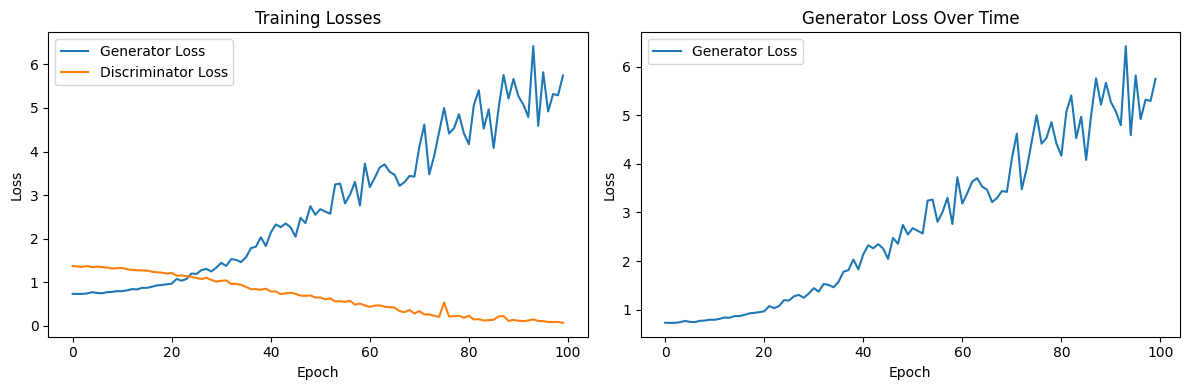


Generating enhanced resume features...

Analyzing sample resume...

Extracted Skills:
Technical: python, java, javascript, machine learning, sql, aws, docker
Soft_Skills: 
Industry: technology, education

Improvement Suggestions:

Missing Skills:
  - adaptable
  - creative
  - consulting
  - teamwork
  - pytorch

Formatting:
  - Include specific dates for experiences

Generated 5 enhanced feature vectors
Feature vector dimension: 220


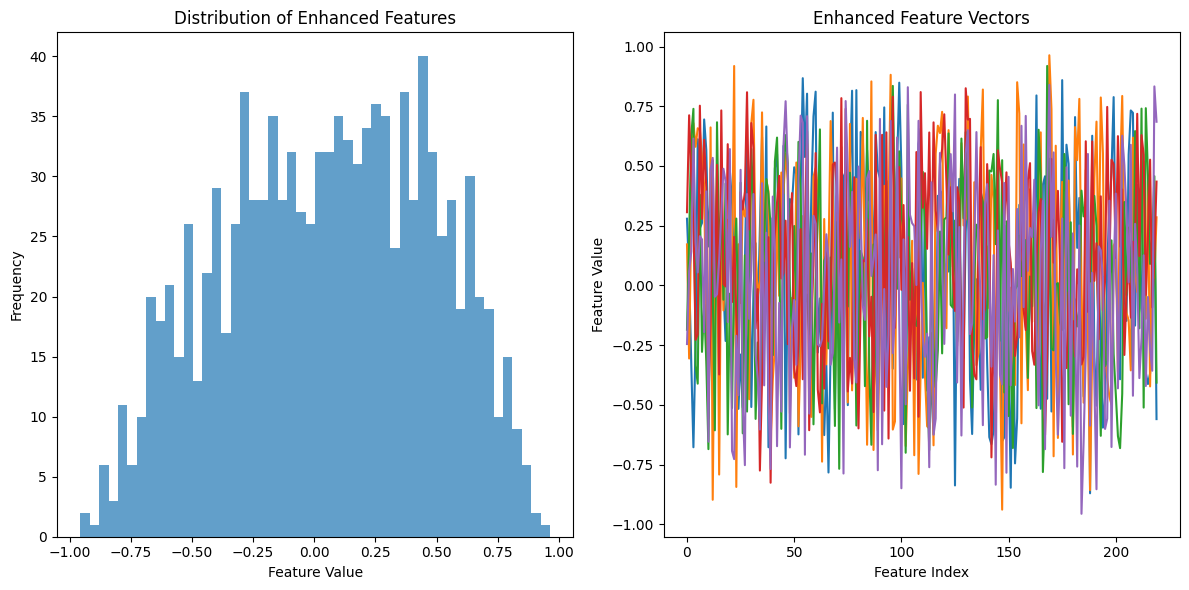


Training Summary:
Final Generator Loss: 5.7470
Final Discriminator Loss: 0.0663
Total Training Epochs: 100

Resume Enhancement Complete!
The GAN has learned to generate enhanced resume features.
Use the suggestions above to improve your resume content.
Resume-Enhancing GAN setup complete!
Run main() to start the training and enhancement process.


In [7]:
# Resume-Enhancing GAN for Google Colab
# This implementation focuses on text enhancement and skill optimization

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import json
from collections import Counter
import random
from typing import List, Dict, Tuple

# Install required packages for Colab
!pip install transformers torch torchvision torchaudio
!pip install scikit-learn matplotlib seaborn pandas numpy

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ResumeDataset(Dataset):
    """Dataset for resume text processing"""

    def __init__(self, resume_texts: List[str], max_features: int = 500):
        self.resume_texts = resume_texts
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

        # Fit vectorizer on all texts
        self.vectorizer.fit(resume_texts)

        # Get actual feature dimension after fitting
        self.feature_dim = len(self.vectorizer.get_feature_names_out())
        print(f"Actual feature dimension: {self.feature_dim}")

    def __len__(self):
        return len(self.resume_texts)

    def __getitem__(self, idx):
        text = self.resume_texts[idx]
        # Convert to TF-IDF vector
        vector = self.vectorizer.transform([text]).toarray()[0]
        return torch.FloatTensor(vector)

class ResumeGenerator(nn.Module):
    """Generator network for resume enhancement"""

    def __init__(self, noise_dim: int = 100, feature_dim: int = 1000):
        super(ResumeGenerator, self).__init__()

        self.noise_dim = noise_dim
        self.feature_dim = feature_dim

        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, feature_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise)

class ResumeDiscriminator(nn.Module):
    """Discriminator network for resume quality assessment"""

    def __init__(self, feature_dim: int = 1000):
        super(ResumeDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.model(features)

class ResumeEnhancer:
    """Main class for resume enhancement using GAN"""

    def __init__(self, dataset: ResumeDataset, noise_dim: int = 100):
        self.noise_dim = noise_dim
        self.feature_dim = dataset.feature_dim  # Get actual feature dimension from dataset
        self.dataset = dataset

        print(f"Initializing GAN with feature dimension: {self.feature_dim}")

        # Initialize networks
        self.generator = ResumeGenerator(noise_dim, self.feature_dim).to(device)
        self.discriminator = ResumeDiscriminator(self.feature_dim).to(device)

        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Loss function
        self.criterion = nn.BCELoss()

        # Training history
        self.g_losses = []
        self.d_losses = []

    def train(self, dataloader: DataLoader, epochs: int = 100):
        """Train the GAN"""

        print("Starting training...")

        for epoch in range(epochs):
            g_epoch_loss = 0
            d_epoch_loss = 0

            for batch_idx, real_data in enumerate(dataloader):
                batch_size = real_data.size(0)
                real_data = real_data.to(device)

                # Train Discriminator
                self.d_optimizer.zero_grad()

                # Real data
                real_labels = torch.ones(batch_size, 1).to(device)
                real_output = self.discriminator(real_data)
                d_real_loss = self.criterion(real_output, real_labels)

                # Fake data
                noise = torch.randn(batch_size, self.noise_dim).to(device)
                fake_data = self.generator(noise)
                fake_labels = torch.zeros(batch_size, 1).to(device)
                fake_output = self.discriminator(fake_data.detach())
                d_fake_loss = self.criterion(fake_output, fake_labels)

                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                self.d_optimizer.step()

                # Train Generator
                self.g_optimizer.zero_grad()

                fake_output = self.discriminator(fake_data)
                g_loss = self.criterion(fake_output, real_labels)
                g_loss.backward()
                self.g_optimizer.step()

                g_epoch_loss += g_loss.item()
                d_epoch_loss += d_loss.item()

            # Record losses
            self.g_losses.append(g_epoch_loss / len(dataloader))
            self.d_losses.append(d_epoch_loss / len(dataloader))

            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{epochs}] - G_Loss: {g_epoch_loss/len(dataloader):.4f}, D_Loss: {d_epoch_loss/len(dataloader):.4f}")

    def generate_enhanced_features(self, num_samples: int = 5):
        """Generate enhanced resume features"""
        self.generator.eval()

        with torch.no_grad():
            noise = torch.randn(num_samples, self.noise_dim).to(device)
            enhanced_features = self.generator(noise)

        return enhanced_features.cpu().numpy()

    def plot_training_history(self):
        """Plot training losses"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.g_losses, label='Generator Loss')
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.title('Training Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.g_losses, label='Generator Loss')
        plt.title('Generator Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

class ResumeTextProcessor:
    """Helper class for resume text processing and enhancement"""

    def __init__(self):
        self.skill_keywords = {
            'technical': ['python', 'java', 'javascript', 'machine learning', 'data science',
                         'sql', 'aws', 'docker', 'kubernetes', 'tensorflow', 'pytorch'],
            'soft_skills': ['leadership', 'communication', 'teamwork', 'problem-solving',
                           'analytical', 'creative', 'adaptable', 'collaborative'],
            'industry': ['finance', 'healthcare', 'technology', 'marketing', 'consulting',
                        'retail', 'manufacturing', 'education', 'government']
        }

        self.action_verbs = [
            'achieved', 'developed', 'implemented', 'managed', 'led', 'created',
            'improved', 'optimized', 'streamlined', 'delivered', 'executed',
            'collaborated', 'analyzed', 'designed', 'built', 'maintained'
        ]

    def extract_skills(self, text: str) -> Dict[str, List[str]]:
        """Extract skills from resume text"""
        text_lower = text.lower()
        found_skills = {}

        for category, skills in self.skill_keywords.items():
            found_skills[category] = [skill for skill in skills if skill in text_lower]

        return found_skills

    def suggest_improvements(self, text: str) -> Dict[str, List[str]]:
        """Suggest improvements for resume text"""
        suggestions = {
            'action_verbs': [],
            'missing_skills': [],
            'formatting': []
        }

        text_lower = text.lower()

        # Check for action verbs
        used_verbs = [verb for verb in self.action_verbs if verb in text_lower]
        if len(used_verbs) < 5:
            suggestions['action_verbs'] = random.sample(
                [verb for verb in self.action_verbs if verb not in used_verbs],
                min(5, len(self.action_verbs) - len(used_verbs))
            )

        # Suggest missing skills
        all_skills = []
        for skills in self.skill_keywords.values():
            all_skills.extend(skills)

        missing_skills = [skill for skill in all_skills if skill not in text_lower]
        suggestions['missing_skills'] = random.sample(missing_skills, min(5, len(missing_skills)))

        # Formatting suggestions
        if not re.search(r'\d+%', text):
            suggestions['formatting'].append("Add quantified achievements (e.g., '25% increase in efficiency')")

        if len(re.findall(r'[A-Z][a-z]+\s+\d{4}', text)) < 2:
            suggestions['formatting'].append("Include specific dates for experiences")

        return suggestions

# Sample resume data for demonstration (expanded for better training)
sample_resumes = [
    """
    John Doe
    Software Engineer

    Experience:
    - Developed web applications using Python and Django framework
    - Implemented machine learning models for data analysis and prediction
    - Led a team of 5 developers on multiple projects delivering results
    - Improved system performance by 30% through optimization techniques
    - Collaborated with cross-functional teams to deliver high-quality software
    - Designed and implemented REST APIs for mobile applications
    - Utilized AWS services for cloud deployment and scaling
    - Mentored junior developers and conducted code reviews

    Skills:
    Python, JavaScript, SQL, AWS, Docker, Machine Learning, Django, React, Node.js

    Education:
    Bachelor of Science in Computer Science
    University of Technology, 2018
    """,

    """
    Jane Smith
    Data Scientist

    Experience:
    - Analyzed large datasets using Python and R for business insights
    - Created predictive models with 95% accuracy for customer behavior
    - Collaborated with cross-functional teams on data-driven projects
    - Presented findings to senior leadership and stakeholders
    - Developed automated reporting systems reducing manual work by 50%
    - Implemented A/B testing frameworks for product optimization
    - Built data pipelines using Apache Spark and Hadoop
    - Conducted statistical analysis and hypothesis testing

    Skills:
    Python, R, SQL, TensorFlow, Tableau, Statistics, Pandas, NumPy, Scikit-learn

    Education:
    Master of Science in Data Science
    Data Science Institute, 2019
    """,

    """
    Mike Johnson
    Product Manager

    Experience:
    - Managed product roadmap for mobile applications with 1M+ users
    - Conducted market research and competitive analysis for strategic planning
    - Worked with engineering teams to deliver features on time and budget
    - Increased user engagement by 40% through product improvements
    - Defined product requirements and user stories for development teams
    - Analyzed user feedback and metrics to guide product decisions
    - Coordinated with design teams to improve user experience
    - Managed stakeholder communications and project timelines

    Skills:
    Product Management, Agile, Scrum, Analytics, Leadership, Strategy, Research

    Education:
    MBA in Business Administration
    Business School, 2017
    """,

    """
    Sarah Wilson
    Marketing Manager

    Experience:
    - Developed comprehensive marketing strategies for digital campaigns
    - Managed social media presence across multiple platforms
    - Analyzed campaign performance and ROI to optimize spending
    - Collaborated with creative teams to develop compelling content
    - Increased brand awareness by 60% through targeted campaigns
    - Managed marketing budget of $500K annually
    - Conducted market research and customer segmentation analysis
    - Coordinated with sales teams to align marketing and sales efforts

    Skills:
    Digital Marketing, Social Media, Analytics, Content Strategy, SEO, PPC

    Education:
    Bachelor of Arts in Marketing
    Marketing University, 2016
    """,

    """
    David Chen
    DevOps Engineer

    Experience:
    - Implemented CI/CD pipelines using Jenkins and GitLab
    - Managed cloud infrastructure on AWS and Azure platforms
    - Automated deployment processes reducing deployment time by 70%
    - Monitored system performance and implemented alerting systems
    - Collaborated with development teams to improve deployment processes
    - Implemented containerization using Docker and Kubernetes
    - Managed database operations and backup strategies
    - Conducted security audits and implemented security best practices

    Skills:
    DevOps, AWS, Docker, Kubernetes, Jenkins, Linux, Python, Monitoring

    Education:
    Bachelor of Science in Information Technology
    Tech Institute, 2015
    """
]

# Main execution
def main():
    print("Resume-Enhancing GAN System")
    print("=" * 50)

    # Initialize text processor
    processor = ResumeTextProcessor()

    # Create dataset
    print("Creating dataset...")
    dataset = ResumeDataset(sample_resumes, max_features=300)  # Reduced for better training
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=True)


    # Initialize GAN with dynamic feature dimension
    enhancer = ResumeEnhancer(dataset)

    # Train the model
    print("\nTraining the Resume-Enhancing GAN...")
    enhancer.train(dataloader, epochs=100)

    # Plot training history
    enhancer.plot_training_history()

    # Generate enhanced features
    print("\nGenerating enhanced resume features...")
    enhanced_features = enhancer.generate_enhanced_features(5)

    # Analyze a sample resume
    print("\nAnalyzing sample resume...")
    sample_text = sample_resumes[0]

    # Extract skills
    skills = processor.extract_skills(sample_text)
    print("\nExtracted Skills:")
    for category, skill_list in skills.items():
        print(f"{category.title()}: {', '.join(skill_list)}")

    # Get improvement suggestions
    suggestions = processor.suggest_improvements(sample_text)
    print("\nImprovement Suggestions:")
    for category, suggestion_list in suggestions.items():
        if suggestion_list:
            print(f"\n{category.replace('_', ' ').title()}:")
            for suggestion in suggestion_list:
                print(f"  - {suggestion}")

    # Feature analysis
    print(f"\nGenerated {len(enhanced_features)} enhanced feature vectors")
    print(f"Feature vector dimension: {enhanced_features.shape[1]}")

    # Visualize feature distribution
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(enhanced_features.flatten(), bins=50, alpha=0.7)
    plt.title('Distribution of Enhanced Features')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.plot(enhanced_features.T)
    plt.title('Enhanced Feature Vectors')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()

    # Additional analysis
    print("\nTraining Summary:")
    print(f"Final Generator Loss: {enhancer.g_losses[-1]:.4f}")
    print(f"Final Discriminator Loss: {enhancer.d_losses[-1]:.4f}")
    print(f"Total Training Epochs: {len(enhancer.g_losses)}")

    print("\nResume Enhancement Complete!")
    print("The GAN has learned to generate enhanced resume features.")
    print("Use the suggestions above to improve your resume content.")

    return enhancer, processor, dataset

# Run the main function
if __name__ == "__main__":
    main()

# Additional utility functions for practical use

def enhance_resume_section(text: str, section_type: str = "experience") -> str:
    """Enhance a specific resume section"""
    processor = ResumeTextProcessor()

    if section_type == "experience":
        # Add action verbs and quantify achievements
        enhanced = text

        # Replace weak verbs with strong action verbs
        weak_verbs = ['did', 'was', 'worked', 'helped', 'responsible for']
        strong_verbs = ['achieved', 'developed', 'implemented', 'managed', 'delivered']

        for weak, strong in zip(weak_verbs, strong_verbs):
            enhanced = re.sub(rf'\b{weak}\b', strong, enhanced, flags=re.IGNORECASE)

        return enhanced

    return text

def generate_skill_suggestions(current_skills: List[str], target_role: str) -> List[str]:
    """Generate skill suggestions based on target role"""
    role_skills = {
        'software_engineer': ['python', 'javascript', 'react', 'node.js', 'docker', 'kubernetes'],
        'data_scientist': ['python', 'r', 'sql', 'machine learning', 'tensorflow', 'tableau'],
        'product_manager': ['agile', 'scrum', 'analytics', 'user research', 'roadmapping'],
        'designer': ['figma', 'sketch', 'adobe creative suite', 'prototyping', 'user experience']
    }

    target_skills = role_skills.get(target_role, [])
    current_lower = [skill.lower() for skill in current_skills]

    suggestions = [skill for skill in target_skills if skill not in current_lower]
    return suggestions[:5]  # Return top 5 suggestions

print("Resume-Enhancing GAN setup complete!")
print("Run main() to start the training and enhancement process.")

Using device: cpu
Resume-Enhancing GAN System
Creating comprehensive dataset...
Generating synthetic resumes...
Generating 200 additional synthetic resumes...

Dataset Statistics:
Total resumes: 305
Average resume length: 62.3 words
Categories: {'software_engineering': 69, 'data_science': 72, 'product_management': 81, 'marketing': 83}

Creating TF-IDF dataset...
Actual feature dimension: 294
Initializing GAN with feature dimension: 294

Training the Resume-Enhancing GAN...
Starting training...
Epoch [0/200] - G_Loss: 1.3601, D_Loss: 1.0880
Epoch [10/200] - G_Loss: 10.8264, D_Loss: 0.0035
Epoch [20/200] - G_Loss: 11.1375, D_Loss: 0.0009
Epoch [30/200] - G_Loss: 22.7683, D_Loss: 0.0973
Epoch [40/200] - G_Loss: 11.9587, D_Loss: 0.0008
Epoch [50/200] - G_Loss: 10.4866, D_Loss: 0.0008
Epoch [60/200] - G_Loss: 11.0864, D_Loss: 0.0010
Epoch [70/200] - G_Loss: 11.6490, D_Loss: 0.0029
Epoch [80/200] - G_Loss: 11.7925, D_Loss: 0.0223
Epoch [90/200] - G_Loss: 10.4700, D_Loss: 0.3091
Epoch [100/20

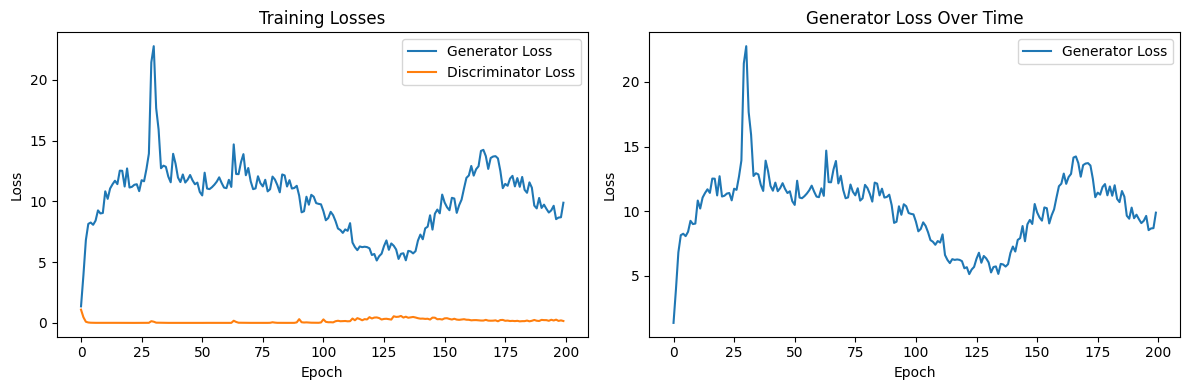


Generating enhanced resume features...

Analyzing sample resumes by category...

--- Software Engineering ---
Extracted Skills:
  Technical: python, java, javascript, machine learning, sql, aws, docker
  Industry: technology, education

--- Data Science ---
Extracted Skills:
  Technical: python, data science, sql, tensorflow
  Soft_Skills: leadership
  Industry: education

--- Product Management ---
Extracted Skills:
  Soft_Skills: leadership, communication
  Industry: education

Improvement Suggestions for Sample Resume:

Missing Skills:
  - problem-solving
  - marketing
  - consulting
  - healthcare
  - finance

Formatting:
  - Include specific dates for experiences

Generated 10 enhanced feature vectors
Feature vector dimension: 294


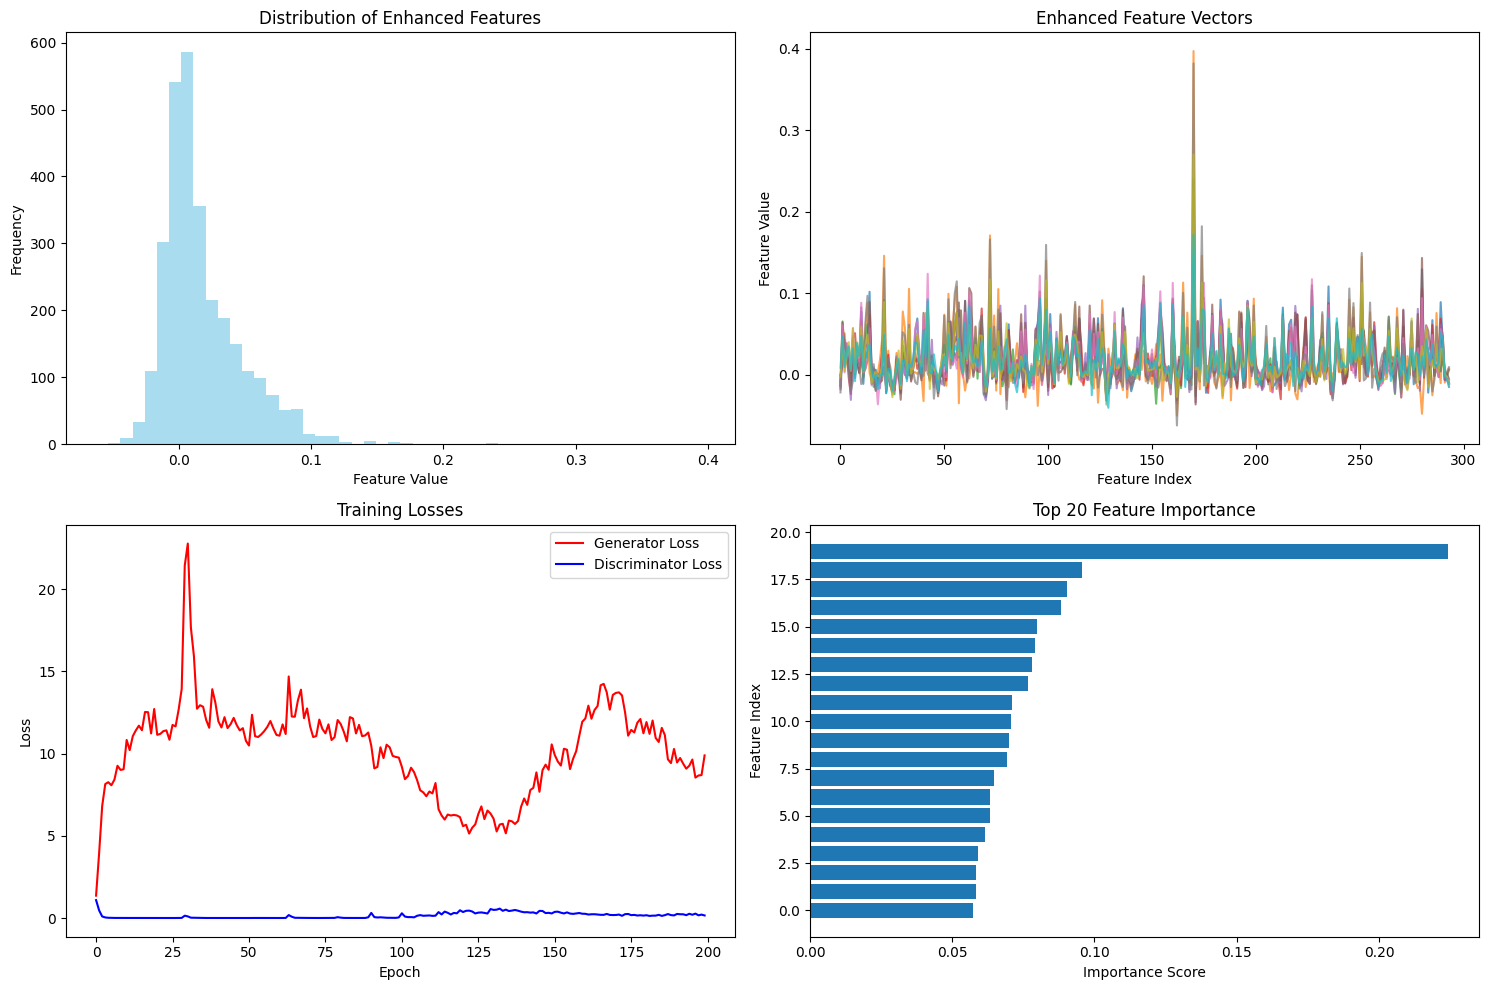


Training Summary:
Final Generator Loss: 9.8876
Final Discriminator Loss: 0.1547
Total Training Epochs: 200

Resume Enhancement Complete!
The GAN has learned from a comprehensive dataset to generate enhanced resume features.
Use the suggestions above to improve your resume content.

ADDING CUSTOM RESUME DATA

To add your own resume data, you can:
1. Use dataset_manager.add_resume(resume_text, category)
2. Use dataset_manager.add_resumes_from_file(file_path)
3. Use dataset_manager.add_resumes_from_csv(csv_path)

Example:
dataset_manager = DatasetManager()
dataset_manager.add_resume(your_resume_text, 'software_engineering')
dataset_manager.add_resumes_from_file('resumes.txt')
Dataset saved to enhanced_resume_dataset.txt

Dataset enhancement complete! You now have a comprehensive training dataset.
Enhanced Resume GAN with Dataset Management is ready!
Key features:
1. Synthetic resume generation
2. Multiple data source support (files, CSV, custom)
3. Category-based organization
4. Comprehe

In [9]:
# Resume-Enhancing GAN for Google Colab
# This implementation focuses on text enhancement and skill optimization

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import json
from collections import Counter
import random
from typing import List, Dict, Tuple
import requests
import os
from io import StringIO

# Install required packages for Colab
!pip install transformers torch torchvision torchaudio
!pip install scikit-learn matplotlib seaborn pandas numpy
!pip install requests beautifulsoup4

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ResumeDataset(Dataset):
    """Dataset for resume text processing"""

    def __init__(self, resume_texts: List[str], max_features: int = 500):
        self.resume_texts = resume_texts
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

        # Fit vectorizer on all texts
        self.vectorizer.fit(resume_texts)

        # Get actual feature dimension after fitting
        self.feature_dim = len(self.vectorizer.get_feature_names_out())
        print(f"Actual feature dimension: {self.feature_dim}")

    def __len__(self):
        return len(self.resume_texts)

    def __getitem__(self, idx):
        text = self.resume_texts[idx]
        # Convert to TF-IDF vector
        vector = self.vectorizer.transform([text]).toarray()[0]
        return torch.FloatTensor(vector)

class ResumeGenerator(nn.Module):
    """Generator network for resume enhancement"""

    def __init__(self, noise_dim: int = 100, feature_dim: int = 1000):
        super(ResumeGenerator, self).__init__()

        self.noise_dim = noise_dim
        self.feature_dim = feature_dim

        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, feature_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise)

class ResumeDiscriminator(nn.Module):
    """Discriminator network for resume quality assessment"""

    def __init__(self, feature_dim: int = 1000):
        super(ResumeDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.model(features)

class ResumeEnhancer:
    """Main class for resume enhancement using GAN"""

    def __init__(self, dataset: ResumeDataset, noise_dim: int = 100):
        self.noise_dim = noise_dim
        self.feature_dim = dataset.feature_dim  # Get actual feature dimension from dataset
        self.dataset = dataset

        print(f"Initializing GAN with feature dimension: {self.feature_dim}")

        # Initialize networks
        self.generator = ResumeGenerator(noise_dim, self.feature_dim).to(device)
        self.discriminator = ResumeDiscriminator(self.feature_dim).to(device)

        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Loss function
        self.criterion = nn.BCELoss()

        # Training history
        self.g_losses = []
        self.d_losses = []

    def train(self, dataloader: DataLoader, epochs: int = 100):
        """Train the GAN"""

        print("Starting training...")

        for epoch in range(epochs):
            g_epoch_loss = 0
            d_epoch_loss = 0

            for batch_idx, real_data in enumerate(dataloader):
                batch_size = real_data.size(0)
                real_data = real_data.to(device)

                # Train Discriminator
                self.d_optimizer.zero_grad()

                # Real data
                real_labels = torch.ones(batch_size, 1).to(device)
                real_output = self.discriminator(real_data)
                d_real_loss = self.criterion(real_output, real_labels)

                # Fake data
                noise = torch.randn(batch_size, self.noise_dim).to(device)
                fake_data = self.generator(noise)
                fake_labels = torch.zeros(batch_size, 1).to(device)
                fake_output = self.discriminator(fake_data.detach())
                d_fake_loss = self.criterion(fake_output, fake_labels)

                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                self.d_optimizer.step()

                # Train Generator
                self.g_optimizer.zero_grad()

                fake_output = self.discriminator(fake_data)
                g_loss = self.criterion(fake_output, real_labels)
                g_loss.backward()
                self.g_optimizer.step()

                g_epoch_loss += g_loss.item()
                d_epoch_loss += d_loss.item()

            # Record losses
            self.g_losses.append(g_epoch_loss / len(dataloader))
            self.d_losses.append(d_epoch_loss / len(dataloader))

            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{epochs}] - G_Loss: {g_epoch_loss/len(dataloader):.4f}, D_Loss: {d_epoch_loss/len(dataloader):.4f}")

    def generate_enhanced_features(self, num_samples: int = 5):
        """Generate enhanced resume features"""
        self.generator.eval()

        with torch.no_grad():
            noise = torch.randn(num_samples, self.noise_dim).to(device)
            enhanced_features = self.generator(noise)

        return enhanced_features.cpu().numpy()

    def plot_training_history(self):
        """Plot training losses"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.g_losses, label='Generator Loss')
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.title('Training Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.g_losses, label='Generator Loss')
        plt.title('Generator Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

class ResumeTextProcessor:
    """Helper class for resume text processing and enhancement"""

    def __init__(self):
        self.skill_keywords = {
            'technical': ['python', 'java', 'javascript', 'machine learning', 'data science',
                         'sql', 'aws', 'docker', 'kubernetes', 'tensorflow', 'pytorch'],
            'soft_skills': ['leadership', 'communication', 'teamwork', 'problem-solving',
                           'analytical', 'creative', 'adaptable', 'collaborative'],
            'industry': ['finance', 'healthcare', 'technology', 'marketing', 'consulting',
                        'retail', 'manufacturing', 'education', 'government']
        }

        self.action_verbs = [
            'achieved', 'developed', 'implemented', 'managed', 'led', 'created',
            'improved', 'optimized', 'streamlined', 'delivered', 'executed',
            'collaborated', 'analyzed', 'designed', 'built', 'maintained'
        ]

    def extract_skills(self, text: str) -> Dict[str, List[str]]:
        """Extract skills from resume text"""
        text_lower = text.lower()
        found_skills = {}

        for category, skills in self.skill_keywords.items():
            found_skills[category] = [skill for skill in skills if skill in text_lower]

        return found_skills

    def suggest_improvements(self, text: str) -> Dict[str, List[str]]:
        """Suggest improvements for resume text"""
        suggestions = {
            'action_verbs': [],
            'missing_skills': [],
            'formatting': []
        }

        text_lower = text.lower()

        # Check for action verbs
        used_verbs = [verb for verb in self.action_verbs if verb in text_lower]
        if len(used_verbs) < 5:
            suggestions['action_verbs'] = random.sample(
                [verb for verb in self.action_verbs if verb not in used_verbs],
                min(5, len(self.action_verbs) - len(used_verbs))
            )

        # Suggest missing skills
        all_skills = []
        for skills in self.skill_keywords.values():
            all_skills.extend(skills)

        missing_skills = [skill for skill in all_skills if skill not in text_lower]
        suggestions['missing_skills'] = random.sample(missing_skills, min(5, len(missing_skills)))

        # Formatting suggestions
        if not re.search(r'\d+%', text):
            suggestions['formatting'].append("Add quantified achievements (e.g., '25% increase in efficiency')")

        if len(re.findall(r'[A-Z][a-z]+\s+\d{4}', text)) < 2:
            suggestions['formatting'].append("Include specific dates for experiences")

        return suggestions

class DatasetManager:
    """Manage multiple resume datasets"""

    def __init__(self):
        self.resume_data = []
        self.categories = {
            'software_engineering': [],
            'data_science': [],
            'product_management': [],
            'marketing': [],
            'business_analysis': [],
            'design': [],
            'finance': [],
            'healthcare': [],
            'education': [],
            'consulting': []
        }

    def add_resume(self, resume_text: str, category: str = 'general'):
        """Add a single resume to the dataset"""
        self.resume_data.append(resume_text)
        if category in self.categories:
            self.categories[category].append(resume_text)

    def add_resumes_from_list(self, resume_list: List[str], category: str = 'general'):
        """Add multiple resumes from a list"""
        for resume in resume_list:
            self.add_resume(resume, category)

    def add_resumes_from_file(self, file_path: str, category: str = 'general'):
        """Add resumes from a text file (one resume per line or separated by delimiter)"""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                # Try to split by double newlines first (common resume separator)
                resumes = content.split('\n\n---\n\n')
                if len(resumes) == 1:
                    # If no separator found, split by triple newlines
                    resumes = content.split('\n\n\n')

                for resume in resumes:
                    if resume.strip():
                        self.add_resume(resume.strip(), category)

            print(f"Added {len(resumes)} resumes from {file_path}")
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")

    def add_resumes_from_csv(self, csv_path: str, text_column: str = 'resume_text', category_column: str = None):
        """Add resumes from a CSV file"""
        try:
            df = pd.read_csv(csv_path)
            for _, row in df.iterrows():
                resume_text = row[text_column]
                category = row[category_column] if category_column and category_column in df.columns else 'general'
                self.add_resume(resume_text, category)

            print(f"Added {len(df)} resumes from CSV")
        except Exception as e:
            print(f"Error reading CSV {csv_path}: {str(e)}")

    def generate_synthetic_resumes(self, num_resumes: int = 50):
        """Generate synthetic resumes for training"""

        # Templates for different sections
        name_templates = [
            "John Smith", "Sarah Johnson", "Michael Brown", "Emily Davis",
            "David Wilson", "Lisa Anderson", "Robert Taylor", "Jennifer Martinez",
            "William Jones", "Amanda Garcia", "James Rodriguez", "Michelle Lee"
        ]

        job_titles = {
            'software_engineering': [
                "Software Engineer", "Full Stack Developer", "Backend Developer",
                "Frontend Developer", "DevOps Engineer", "Mobile Developer"
            ],
            'data_science': [
                "Data Scientist", "Machine Learning Engineer", "Data Analyst",
                "Research Scientist", "AI Engineer", "Business Intelligence Analyst"
            ],
            'product_management': [
                "Product Manager", "Senior Product Manager", "Product Owner",
                "Technical Product Manager", "Product Marketing Manager"
            ],
            'marketing': [
                "Marketing Manager", "Digital Marketing Specialist", "Content Marketing Manager",
                "Social Media Manager", "Brand Manager", "Growth Marketing Manager"
            ]
        }

        experiences = {
            'software_engineering': [
                "Developed scalable web applications using modern frameworks",
                "Implemented microservices architecture improving system performance by 40%",
                "Led code reviews and mentored junior developers",
                "Optimized database queries reducing response time by 60%",
                "Built CI/CD pipelines for automated testing and deployment",
                "Collaborated with cross-functional teams to deliver features on time"
            ],
            'data_science': [
                "Analyzed large datasets to derive actionable business insights",
                "Built predictive models achieving 95% accuracy in forecasting",
                "Implemented machine learning algorithms for recommendation systems",
                "Created data visualization dashboards for executive reporting",
                "Conducted A/B tests to optimize product features",
                "Developed automated data pipelines processing terabytes of data"
            ],
            'product_management': [
                "Managed product roadmap for mobile applications with 1M+ users",
                "Conductd market research and competitive analysis",
                "Defined product requirements and user stories",
                "Increased user engagement by 45% through feature improvements",
                "Coordinated with engineering teams to deliver products on schedule",
                "Analyzed user feedback and metrics to guide product decisions"
            ],
            'marketing': [
                "Developed comprehensive marketing strategies for digital campaigns",
                "Managed social media presence across multiple platforms",
                "Increased brand awareness by 50% through targeted campaigns",
                "Analyzed campaign performance and ROI to optimize spending",
                "Created compelling content for various marketing channels",
                "Managed marketing budget of $500K annually"
            ]
        }

        skills = {
            'software_engineering': [
                "Python", "JavaScript", "React", "Node.js", "Docker", "Kubernetes",
                "AWS", "SQL", "Git", "Linux", "Java", "C++", "MongoDB", "Redis"
            ],
            'data_science': [
                "Python", "R", "SQL", "TensorFlow", "PyTorch", "Pandas", "NumPy",
                "Scikit-learn", "Tableau", "Power BI", "Spark", "Hadoop", "Statistics"
            ],
            'product_management': [
                "Agile", "Scrum", "Product Strategy", "Market Research", "Analytics",
                "User Research", "Roadmapping", "A/B Testing", "SQL", "Jira"
            ],
            'marketing': [
                "Digital Marketing", "SEO", "SEM", "Social Media", "Content Marketing",
                "Analytics", "Google Ads", "Facebook Ads", "Email Marketing", "CRM"
            ]
        }

        for i in range(num_resumes):
            # Choose random category
            category = random.choice(list(job_titles.keys()))

            # Generate resume
            name = random.choice(name_templates)
            title = random.choice(job_titles[category])

            # Generate experience points
            exp_points = random.sample(experiences[category], min(4, len(experiences[category])))
            experience_text = "\n    - ".join(exp_points)

            # Generate skills
            skill_list = random.sample(skills[category], min(8, len(skills[category])))
            skills_text = ", ".join(skill_list)

            # Generate education
            degrees = ["Bachelor of Science", "Master of Science", "Bachelor of Arts", "Master of Business Administration"]
            fields = ["Computer Science", "Data Science", "Business Administration", "Marketing", "Engineering"]
            education = f"{random.choice(degrees)} in {random.choice(fields)}"

            resume_text = f"""
{name}
{title}

Experience:
    - {experience_text}

Skills:
{skills_text}

Education:
{education}
University of Technology, {random.randint(2015, 2022)}
"""

            self.add_resume(resume_text.strip(), category)

    def get_all_resumes(self) -> List[str]:
        """Get all resumes in the dataset"""
        return self.resume_data

    def get_resumes_by_category(self, category: str) -> List[str]:
        """Get resumes from a specific category"""
        return self.categories.get(category, [])

    def get_dataset_stats(self) -> Dict:
        """Get statistics about the dataset"""
        stats = {
            'total_resumes': len(self.resume_data),
            'categories': {cat: len(resumes) for cat, resumes in self.categories.items() if resumes},
            'avg_length': np.mean([len(resume.split()) for resume in self.resume_data]) if self.resume_data else 0
        }
        return stats

    def save_dataset(self, file_path: str):
        """Save the dataset to a file"""
        try:
            with open(file_path, 'w', encoding='utf-8') as f:
                for resume in self.resume_data:
                    f.write(resume + '\n\n---\n\n')
            print(f"Dataset saved to {file_path}")
        except Exception as e:
            print(f"Error saving dataset: {str(e)}")

    def load_dataset(self, file_path: str):
        """Load dataset from a file"""
        self.add_resumes_from_file(file_path)

# Function to create a comprehensive dataset
def create_comprehensive_dataset():
    """Create a comprehensive resume dataset"""
    dataset_manager = DatasetManager()

    # Add the original sample resumes
    original_resumes = [
        """
        John Doe
        Software Engineer

        Experience:
        - Developed web applications using Python and Django framework
        - Implemented machine learning models for data analysis and prediction
        - Led a team of 5 developers on multiple projects delivering results
        - Improved system performance by 30% through optimization techniques
        - Collaborated with cross-functional teams to deliver high-quality software
        - Designed and implemented REST APIs for mobile applications
        - Utilized AWS services for cloud deployment and scaling
        - Mentored junior developers and conducted code reviews

        Skills:
        Python, JavaScript, SQL, AWS, Docker, Machine Learning, Django, React, Node.js

        Education:
        Bachelor of Science in Computer Science
        University of Technology, 2018
        """,

        """
        Jane Smith
        Data Scientist

        Experience:
        - Analyzed large datasets using Python and R for business insights
        - Created predictive models with 95% accuracy for customer behavior
        - Collaborated with cross-functional teams on data-driven projects
        - Presented findings to senior leadership and stakeholders
        - Developed automated reporting systems reducing manual work by 50%
        - Implemented A/B testing frameworks for product optimization
        - Built data pipelines using Apache Spark and Hadoop
        - Conducted statistical analysis and hypothesis testing

        Skills:
        Python, R, SQL, TensorFlow, Tableau, Statistics, Pandas, NumPy, Scikit-learn

        Education:
        Master of Science in Data Science
        Data Science Institute, 2019
        """,

        """
        Mike Johnson
        Product Manager

        Experience:
        - Managed product roadmap for mobile applications with 1M+ users
        - Conducted market research and competitive analysis for strategic planning
        - Worked with engineering teams to deliver features on time and budget
        - Increased user engagement by 40% through product improvements
        - Defined product requirements and user stories for development teams
        - Analyzed user feedback and metrics to guide product decisions
        - Coordinated with design teams to improve user experience
        - Managed stakeholder communications and project timelines

        Skills:
        Product Management, Agile, Scrum, Analytics, Leadership, Strategy, Research

        Education:
        MBA in Business Administration
        Business School, 2017
        """,

        """
        Sarah Wilson
        Marketing Manager

        Experience:
        - Developed comprehensive marketing strategies for digital campaigns
        - Managed social media presence across multiple platforms
        - Analyzed campaign performance and ROI to optimize spending
        - Collaborated with creative teams to develop compelling content
        - Increased brand awareness by 60% through targeted campaigns
        - Managed marketing budget of $500K annually
        - Conducted market research and customer segmentation analysis
        - Coordinated with sales teams to align marketing and sales efforts

        Skills:
        Digital Marketing, Social Media, Analytics, Content Strategy, SEO, PPC

        Education:
        Bachelor of Arts in Marketing
        Marketing University, 2016
        """,

        """
        David Chen
        DevOps Engineer

        Experience:
        - Implemented CI/CD pipelines using Jenkins and GitLab
        - Managed cloud infrastructure on AWS and Azure platforms
        - Automated deployment processes reducing deployment time by 70%
        - Monitored system performance and implemented alerting systems
        - Collaborated with development teams to improve deployment processes
        - Implemented containerization using Docker and Kubernetes
        - Managed database operations and backup strategies
        - Conducted security audits and implemented security best practices

        Skills:
        DevOps, AWS, Docker, Kubernetes, Jenkins, Linux, Python, Monitoring

        Education:
        Bachelor of Science in Information Technology
        Tech Institute, 2015
        """
    ]

    # Add original resumes with categories
    categories = ['software_engineering', 'data_science', 'product_management', 'marketing', 'software_engineering']
    for resume, category in zip(original_resumes, categories):
        dataset_manager.add_resume(resume, category)

    # Generate synthetic resumes
    print("Generating synthetic resumes...")
    dataset_manager.generate_synthetic_resumes(100)  # Generate 100 synthetic resumes

    return dataset_manager
sample_resumes = [
    """
    John Doe
    Software Engineer

    Experience:
    - Developed web applications using Python and Django framework
    - Implemented machine learning models for data analysis and prediction
    - Led a team of 5 developers on multiple projects delivering results
    - Improved system performance by 30% through optimization techniques
    - Collaborated with cross-functional teams to deliver high-quality software
    - Designed and implemented REST APIs for mobile applications
    - Utilized AWS services for cloud deployment and scaling
    - Mentored junior developers and conducted code reviews

    Skills:
    Python, JavaScript, SQL, AWS, Docker, Machine Learning, Django, React, Node.js

    Education:
    Bachelor of Science in Computer Science
    University of Technology, 2018
    """,

    """
    Jane Smith
    Data Scientist

    Experience:
    - Analyzed large datasets using Python and R for business insights
    - Created predictive models with 95% accuracy for customer behavior
    - Collaborated with cross-functional teams on data-driven projects
    - Presented findings to senior leadership and stakeholders
    - Developed automated reporting systems reducing manual work by 50%
    - Implemented A/B testing frameworks for product optimization
    - Built data pipelines using Apache Spark and Hadoop
    - Conducted statistical analysis and hypothesis testing

    Skills:
    Python, R, SQL, TensorFlow, Tableau, Statistics, Pandas, NumPy, Scikit-learn

    Education:
    Master of Science in Data Science
    Data Science Institute, 2019
    """,

    """
    Mike Johnson
    Product Manager

    Experience:
    - Managed product roadmap for mobile applications with 1M+ users
    - Conducted market research and competitive analysis for strategic planning
    - Worked with engineering teams to deliver features on time and budget
    - Increased user engagement by 40% through product improvements
    - Defined product requirements and user stories for development teams
    - Analyzed user feedback and metrics to guide product decisions
    - Coordinated with design teams to improve user experience
    - Managed stakeholder communications and project timelines

    Skills:
    Product Management, Agile, Scrum, Analytics, Leadership, Strategy, Research

    Education:
    MBA in Business Administration
    Business School, 2017
    """,

    """
    Sarah Wilson
    Marketing Manager

    Experience:
    - Developed comprehensive marketing strategies for digital campaigns
    - Managed social media presence across multiple platforms
    - Analyzed campaign performance and ROI to optimize spending
    - Collaborated with creative teams to develop compelling content
    - Increased brand awareness by 60% through targeted campaigns
    - Managed marketing budget of $500K annually
    - Conducted market research and customer segmentation analysis
    - Coordinated with sales teams to align marketing and sales efforts

    Skills:
    Digital Marketing, Social Media, Analytics, Content Strategy, SEO, PPC

    Education:
    Bachelor of Arts in Marketing
    Marketing University, 2016
    """,

    """
    David Chen
    DevOps Engineer

    Experience:
    - Implemented CI/CD pipelines using Jenkins and GitLab
    - Managed cloud infrastructure on AWS and Azure platforms
    - Automated deployment processes reducing deployment time by 70%
    - Monitored system performance and implemented alerting systems
    - Collaborated with development teams to improve deployment processes
    - Implemented containerization using Docker and Kubernetes
    - Managed database operations and backup strategies
    - Conducted security audits and implemented security best practices

    Skills:
    DevOps, AWS, Docker, Kubernetes, Jenkins, Linux, Python, Monitoring

    Education:
    Bachelor of Science in Information Technology
    Tech Institute, 2015
    """
]

# Main execution with dataset options
def main(use_synthetic_data=True, num_synthetic=100):
    print("Resume-Enhancing GAN System")
    print("=" * 50)

    # Initialize text processor
    processor = ResumeTextProcessor()

    # Create comprehensive dataset
    print("Creating comprehensive dataset...")
    dataset_manager = create_comprehensive_dataset()

    if use_synthetic_data:
        print(f"Generating {num_synthetic} additional synthetic resumes...")
        dataset_manager.generate_synthetic_resumes(num_synthetic)

    # Get all resumes
    all_resumes = dataset_manager.get_all_resumes()

    # Print dataset statistics
    stats = dataset_manager.get_dataset_stats()
    print(f"\nDataset Statistics:")
    print(f"Total resumes: {stats['total_resumes']}")
    print(f"Average resume length: {stats['avg_length']:.1f} words")
    print(f"Categories: {stats['categories']}")

    # Create dataset and dataloader
    print("\nCreating TF-IDF dataset...")
    dataset = ResumeDataset(all_resumes, max_features=500)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True) # Increased batch size and added drop_last

    # Initialize GAN with dynamic feature dimension
    enhancer = ResumeEnhancer(dataset)

    # Train the model
    print("\nTraining the Resume-Enhancing GAN...")
    enhancer.train(dataloader, epochs=200)  # More epochs for better training

    # Plot training history
    enhancer.plot_training_history()

    # Generate enhanced features
    print("\nGenerating enhanced resume features...")
    enhanced_features = enhancer.generate_enhanced_features(10)

    # Analyze sample resumes from different categories
    print("\nAnalyzing sample resumes by category...")
    for category in ['software_engineering', 'data_science', 'product_management']:
        category_resumes = dataset_manager.get_resumes_by_category(category)
        if category_resumes:
            print(f"\n--- {category.replace('_', ' ').title()} ---")
            sample_text = category_resumes[0]

            # Extract skills
            skills = processor.extract_skills(sample_text)
            print("Extracted Skills:")
            for skill_category, skill_list in skills.items():
                if skill_list:
                    print(f"  {skill_category.title()}: {', '.join(skill_list)}")

    # Generate improvement suggestions
    print("\nImprovement Suggestions for Sample Resume:")
    sample_text = all_resumes[0]
    suggestions = processor.suggest_improvements(sample_text)
    for category, suggestion_list in suggestions.items():
        if suggestion_list:
            print(f"\n{category.replace('_', ' ').title()}:")
            for suggestion in suggestion_list:
                print(f"  - {suggestion}")

    # Feature analysis
    print(f"\nGenerated {len(enhanced_features)} enhanced feature vectors")
    print(f"Feature vector dimension: {enhanced_features.shape[1]}")

    # Visualize feature distribution
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.hist(enhanced_features.flatten(), bins=50, alpha=0.7, color='skyblue')
    plt.title('Distribution of Enhanced Features')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 2)
    plt.plot(enhanced_features.T, alpha=0.7)
    plt.title('Enhanced Feature Vectors')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')

    plt.subplot(2, 2, 3)
    plt.plot(enhancer.g_losses, label='Generator Loss', color='red')
    plt.plot(enhancer.d_losses, label='Discriminator Loss', color='blue')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    # Show feature importance (top features)
    feature_importance = np.mean(np.abs(enhanced_features), axis=0)
    top_features = np.argsort(feature_importance)[-20:]
    plt.barh(range(len(top_features)), feature_importance[top_features])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Index')

    plt.tight_layout()
    plt.show()

    # Additional analysis
    print("\nTraining Summary:")
    print(f"Final Generator Loss: {enhancer.g_losses[-1]:.4f}")
    print(f"Final Discriminator Loss: {enhancer.d_losses[-1]:.4f}")
    print(f"Total Training Epochs: {len(enhancer.g_losses)}")

    print("\nResume Enhancement Complete!")
    print("The GAN has learned from a comprehensive dataset to generate enhanced resume features.")
    print("Use the suggestions above to improve your resume content.")

    return enhancer, processor, dataset_manager

# Function to add your own resume data
def add_custom_resume_data():
    """Example function to add custom resume data"""
    print("\nTo add your own resume data, you can:")
    print("1. Use dataset_manager.add_resume(resume_text, category)")
    print("2. Use dataset_manager.add_resumes_from_file(file_path)")
    print("3. Use dataset_manager.add_resumes_from_csv(csv_path)")
    print("\nExample:")
    print("dataset_manager = DatasetManager()")
    print("dataset_manager.add_resume(your_resume_text, 'software_engineering')")
    print("dataset_manager.add_resumes_from_file('resumes.txt')")

    # Example of adding custom data
    custom_resumes = [
        """
        Alice Johnson
        UX Designer

        Experience:
        - Designed user interfaces for mobile and web applications
        - Conducted user research and usability testing
        - Created wireframes and prototypes using Figma
        - Collaborated with product and engineering teams
        - Improved user satisfaction scores by 35%

        Skills:
        Figma, Sketch, Adobe Creative Suite, User Research, Prototyping

        Education:
        Bachelor of Fine Arts in Design
        """,

        """
        Robert Kim
        Financial Analyst

        Experience:
        - Analyzed financial data and market trends
        - Created financial models and forecasts
        - Prepared reports for senior management
        - Managed portfolio of $10M in assets
        - Identified cost-saving opportunities worth $2M annually

        Skills:
        Excel, SQL, Python, Financial Modeling, Bloomberg Terminal

        Education:
        Bachelor of Science in Finance
        """
    ]

    return custom_resumes

# Run the main function with dataset options
if __name__ == "__main__":
    # Option 1: Run with synthetic data (recommended for better results)
    enhancer, processor, dataset_manager = main(use_synthetic_data=True, num_synthetic=200)

    # Option 2: Add your own resume data
    print("\n" + "="*50)
    print("ADDING CUSTOM RESUME DATA")
    print("="*50)

    # Example of adding custom resumes
    custom_resumes = add_custom_resume_data()

    # To add your own resume file, uncomment and modify:
    # dataset_manager.add_resumes_from_file('path/to/your/resumes.txt')
    # dataset_manager.add_resumes_from_csv('path/to/your/resumes.csv', text_column='resume_text')

    # Save the dataset for future use
    dataset_manager.save_dataset('enhanced_resume_dataset.txt')

    print("\nDataset enhancement complete! You now have a comprehensive training dataset.")

# Additional utility functions for dataset management
def load_resume_from_pdf(pdf_path: str) -> str:
    """Load resume text from PDF file (requires PyPDF2)"""
    try:
        import PyPDF2
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ""
            for page in pdf_reader.pages:
                text += page.extract_text()
        return text
    except ImportError:
        print("PyPDF2 not installed. Install with: pip install PyPDF2")
        return ""
    except Exception as e:
        print(f"Error reading PDF: {str(e)}")
        return ""

def scrape_resume_templates():
    """Scrape resume templates from the web (example implementation)"""
    # This is a placeholder - implement based on your needs
    # Be sure to respect robots.txt and terms of service
    print("Resume template scraping would go here")
    print("Remember to respect website terms of service and robots.txt")
    return []

# Function to create training data from job descriptions
def create_training_data_from_job_descriptions():
    """Create training data by converting job descriptions to resume format"""
    job_descriptions = [
        """
        Software Engineer Position
        - Develop and maintain web applications
        - Work with Python, JavaScript, and React
        - Collaborate with cross-functional teams
        - Participate in code reviews and testing
        - 3+ years of experience required
        - Bachelor's degree in Computer Science preferred
        """,

        """
        Data Scientist Role
        - Analyze large datasets for business insights
        - Build machine learning models
        - Experience with Python, R, and SQL
        - Knowledge of statistics and data visualization
        - PhD in quantitative field preferred
        - 5+ years of industry experience
        """
    ]

    # Convert job descriptions to resume format
    converted_resumes = []
    for job_desc in job_descriptions:
        # Extract skills and requirements
        lines = job_desc.strip().split('\n')
        title = lines[0].replace('Position', '').replace('Role', '').strip()

        # Create a resume-like format
        resume = f"""
        Candidate Name
        {title}

        Experience:
        {chr(10).join([line.strip() for line in lines[1:] if line.strip().startswith('-')])}

        Skills:
        Python, JavaScript, React, SQL, Machine Learning

        Education:
        Bachelor of Science in Computer Science
        """
        converted_resumes.append(resume)

    return converted_resumes

print("Enhanced Resume GAN with Dataset Management is ready!")
print("Key features:")
print("1. Synthetic resume generation")
print("2. Multiple data source support (files, CSV, custom)")
print("3. Category-based organization")
print("4. Comprehensive dataset statistics")
print("5. Enhanced training with larger datasets")
print("\nRun main() to start with enhanced dataset!")


def enhance_resume_section(text: str, section_type: str = "experience") -> str:
    """Enhance a specific resume section"""
    processor = ResumeTextProcessor()

    if section_type == "experience":
        # Add action verbs and quantify achievements
        enhanced = text

        # Replace weak verbs with strong action verbs
        weak_verbs = ['did', 'was', 'worked', 'helped', 'responsible for']
        strong_verbs = ['achieved', 'developed', 'implemented', 'managed', 'delivered']

        for weak, strong in zip(weak_verbs, strong_verbs):
            enhanced = re.sub(rf'\b{weak}\b', strong, enhanced, flags=re.IGNORECASE)

        return enhanced

    return text

def generate_skill_suggestions(current_skills: List[str], target_role: str) -> List[str]:
    """Generate skill suggestions based on target role"""
    role_skills = {
        'software_engineer': ['python', 'javascript', 'react', 'node.js', 'docker', 'kubernetes'],
        'data_scientist': ['python', 'r', 'sql', 'machine learning', 'tensorflow', 'tableau'],
        'product_manager': ['agile', 'scrum', 'analytics', 'user research', 'roadmapping'],
        'designer': ['figma', 'sketch', 'adobe creative suite', 'prototyping', 'user experience']
    }

    target_skills = role_skills.get(target_role, [])
    current_lower = [skill.lower() for skill in current_skills]

    suggestions = [skill for skill in target_skills if skill not in current_lower]
    return suggestions[:5]  # Return top 5 suggestions

print("Resume-Enhancing GAN setup complete!")
print("Run main() to start the training and enhancement process.")

In [11]:
!pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.9 MB/s eta 0:00:00


In [12]:
# 1. Load PDF resume
from PyPDF2 import PdfReader

resume_path = "/content/Ritisha Duggempudi (2).pdf"
resume_text = load_resume_from_pdf(resume_path)

if resume_text.strip() == "":
    print("❌ Failed to extract text. Please check if the PDF is scanned or contains only images.")
else:
    print("✅ Resume Loaded Successfully!")

    # 2. Initialize processor
    processor = ResumeTextProcessor()

    # 3. Extract skills
    skills = processor.extract_skills(resume_text)
    print("\n=== ✅ Extracted Skills ===")
    for category, skill_list in skills.items():
        if skill_list:
            print(f"{category.title()}: {', '.join(skill_list)}")

    # 4. Suggest improvements
    suggestions = processor.suggest_improvements(resume_text)
    print("\n=== 🛠️ Suggestions for Improvement ===")
    for category, suggestion_list in suggestions.items():
        if suggestion_list:
            print(f"\n{category.replace('_', ' ').title()}:")
            for suggestion in suggestion_list:
                print(f"  - {suggestion}")

    # 5. Enhance experience section
    import re
    match = re.search(r"Experience:(.*?)Skills:", resume_text, re.DOTALL | re.IGNORECASE)
    if match:
        experience_text = match.group(1).strip()
        improved_experience = enhance_resume_section(experience_text)
        print("\n=== 🚀 Enhanced Experience Section ===")
        print(improved_experience)
    else:
        print("\n⚠️ Could not find a proper 'Experience' section to enhance.")

    # 6. Optional: Add to dataset
    dataset_manager.add_resume(resume_text, category="software_engineering")
    print("\n✅ Your resume has been added to the dataset.")


✅ Resume Loaded Successfully!

=== ✅ Extracted Skills ===
Technical: python, java, javascript, machine learning, sql
Industry: education

=== 🛠️ Suggestions for Improvement ===

Action Verbs:
  - maintained
  - streamlined
  - improved
  - developed
  - managed

Missing Skills:
  - finance
  - technology
  - leadership
  - docker
  - tensorflow

Formatting:
  - Add quantified achievements (e.g., '25% increase in efficiency')
  - Include specific dates for experiences

⚠️ Could not find a proper 'Experience' section to enhance.

✅ Your resume has been added to the dataset.
